# TP 6 -  Sampling random numbers


<h4 align="right"> Hicham Janati </h4>


In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import tqdm

### 


# 1- pseudo-random generators

The generator RANDU is a linear pseudo-random generator defined by the sequence of division rests on all integers of a 32-bit system:
$$ x_{n+1} = (2^{16} + 3) x_n \text{ mod } [2^{31}] $$
so that the sequence $$u_{n} = \frac{x_n}{2^{31}}$$ follows a uniform distribution over [0, 1]. The purpose of this exercise is to show why RANDU is considered one of the worst pseudo-random generators of all time.

In [2]:
def randu(N, seed=1, tqdm_indicator=False):
    """RANDU generator.
    N: int.
        number of samples.
    s: int.
        random seed.
    """
    U = np.zeros(N)
    x = seed
    twopower31 = 2**31
    r = (2 ** 16 + 3)
    if tqdm_indicator == True:
        for i in tqdm.tqdm(range(N)):
            a = r * x
            x = a % twopower31
            U[i] = x / twopower31
    else:
        for i in range(N):
            a = (2 ** 16 + 3) * x
            x = a % (2 ** 31)
            U[i] = x / (2**31)
    return U


### Question 1.
Show that after $2^{31}$ iterations, each integer between 0 and $2^{31}-1$ has been returned once and only once. 

In [3]:
U = randu(2**31, tqdm_indicator=True)

100%|██████████| 2147483648/2147483648 [17:13<00:00, 2077921.95it/s]


In [10]:
print(U[0], U[2**28], U[2**29], U[0]-U[2**29])  # U[2**29] = U[0], 2**31 = 4 * 2**29

3.051897510886192e-05 0.5000305189751089 3.051897510886192e-05 0.0


After one quarter of an hour, we can see that what was asked to show in the question was false. About 3 quarters of the integers have never been returned in the sequence x_n. In fact, only odd numbers can appear.

### Question 2.
Generate 10000 samples using RANDU and plot $u_{n+1}$ as a function of $u_{n}$ for all $u_{n} \in [0.5, 0.51]$. What do you observe ?

In [ ]:
U = randu(10000)
ind = np.where(0.5 <= U and U <= 0.51)
if ind[-1] == 10000-1:
    ind = ind[:-1]
plt.plot(U[ind], U[ind+1], '.')

The plot really looks like a i.i.d. uniform distribution.

#### Question 3. 
Generate 10000 samples using RANDU and plot $u_{n+2}$ as a function of $u_{n}$ for all $u_{n+1} \in [0.5, 0.51]$. What do you observe ?

In [ ]:
U = randu(10000)
ind = np.where(0.5 <= U and U <= 0.51)
if ind[-1] == 10000-1:
    ind = ind[:-1]
if ind[0] == 0:
    ind = ind[1:]
plt.plot(U[ind-1], U[ind+1], '.')

Now, the plot show that the distribution is not i.i.d

#### Question 2. 
 Visualize this phenomenon using a 3 dimensions plot

#### Question 4
An easy way to write an integer in base 2 is:

In [11]:
x = 14
x_bin = int("{0:b}".format(x))
x_bin

1110

Show that the last bits (the ones with low weight) of a RANDU sequence have a very small cycling period.

The pseudo-randomg generator used in Numpy (and most programming languages) is based on the Mersenne Twister algorithm which, loosely speaking is based on a buffer of size m i.e when given a seed $x_0$, the first generated output would be $x_{m+1}$. This makes it enjoy better statistical properties. 

# 2 - Sampling: inversing the CDF and rejection sampling
1. Assume we now have a (reliable) pseudo-random generator RAND of a uniform distribution in [0, 1]. How can we generate samples following a different distribution with known CDF F using uniform samples from RAND using the <a href=https://en.wikipedia.org/wiki/Inverse_transform_sampling> inversion theorem </a>?

2. Applying this strategy to the exponential distribution, implement a generator of samples following the exponential 
distribution of parameter $\alpha$. 
Compare the histogram of the samples you generate with the desired density.

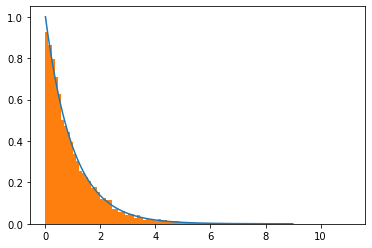

In [7]:
alpha = 1
def F_inverse(x):
    return -1/alpha * np.log(1-x)

def rand_exp(N):
    U = np.random.rand(N)
    return F_inverse(U)

x = np.arange(0, 9, 0.01)
plt.plot(x, np.exp(-alpha*x))
plt.hist(rand_exp(10000), 100, density=True);


3. Consider a random variable X following an exponential distribution with parameter $\alpha$. Determine the distribution of the integer part of X i.e the distribution of floor(X). Deduce a random generator for the geometric distribution.


4. Apply this strategy to write a pseudo-random generator of samples following the Laplace distribution with density:
$$ p(x) = \frac{1}{2}\exp(-|x|)$$

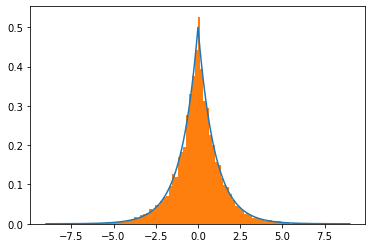

In [10]:
def rand_lap(N):
    X = rand_exp(N)
    U = np.random.rand(N)
    return X * np.sign(U-0.5)


x = np.arange(-9, 9, 0.01)
plt.plot(x, 0.5 * np.exp(-np.abs(x)))
plt.hist(rand_lap(10000), 100, density=True);

5. Assume we want to sample from a distribution with density f(x). The <a href=https://en.wikipedia.org/wiki/Rejection_sampling> rejection sampling</a> method generates samples so as "to fill the area" below the graph of the density function. To do so, one must have a method to sample from an area "surrounding" the density function graph and accept the sample if the point is below the graph, reject it otherwise.

Let f be the centered and normalized Gaussian density function. Find the smallest constant M such that $f(x) \leq Mp(x)$. Using $p(x)$ where $p$ is the Laplace distribution a surrogate function for the Gaussian density, write a generator of Gaussian samples based the accept-reject method.

290 ms ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


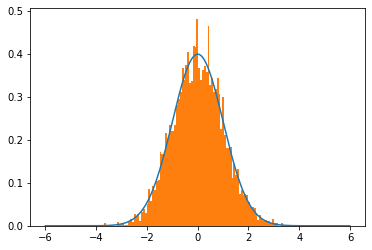

In [34]:
def f(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)
def p(x):
    return 0.5 * np.exp(-np.abs(x))
M = 2*np.exp(1/2)/np.sqrt(2*np.pi)

def rand_gauss(N):
    X = np.zeros(N)
    for i in range(N):
        while True:
            X[i] = rand_lap(1)
            U = np.random.rand(1)
            if f(X[i]) > M * p(X[i]):
                print('oups')
            if U <= f(X[i]) / M / p(X[i]):
                break
    return X

x = np.arange(-6, 6, 0.01)
plt.plot(x, f(x))
%timeit X = rand_gauss(10000)
plt.hist(X, 100, density=True);

6. Can we do the opposite ? Generate Laplace samples using a Gaussian generator via accept-reject ?

No, because there is no M such that p(x) <= M f(x)

## 3 - Sampling: Box-Muller algorithm

The Box-Muller algorithm has been designed to generate Gaussian samples efficiently. It bases on uniform random variables but instead of using the inverse CDF, it uses an alternative formulation.


Consider the following algorithm: 
1. Sample two random variables $U_1, U_2 \sim U[0, 1]$.
2. Define $X = \sqrt{-2\log(U_1)}\sin(2\pi U_2)$ and $Y = \sqrt{-2\log(U_1)}\cos(2\pi U_2)$.


##### Question 1.
By an appropriate change of variable, show that $X, Y$ are independent and follow $\mathcal{N}(0, 1)$.

Soit $(U, V)$ uniformément distribués sur $[0, 1]$ montrons que $X, Y = g(U, V)$ suit $\mathcal{N}(0, I_2)$ avec $g$:
 On a:
$$ \begin{pmatrix} X \\ Y \end{pmatrix} 
= g \left( \begin{pmatrix} U \\ V \end{pmatrix} \right)
= \begin{pmatrix} g_1(U,V) \\ g_2(U,V) \end{pmatrix}
$$
Où
$$\begin{array}{ccccc}
g_1 & : & ]0,1]^2 & \to & \mathbb{R} \\
 & & (x,y) & \mapsto & \sqrt{-2 \ln(x)} \cos(2\pi y) \\
\end{array} 
$$
et
$$\begin{array}{ccccc}
g_2 & : & ]0,1]^2 & \to & \mathbb{R} \\
 & & (x,y) & \mapsto & \sqrt{-2 \ln(x)} \sin(2\pi y) \\
\end{array} 
$$
On peut facilement montrer que g est bijective (prendre la somme des carrés pour éliminer $cos^2 + sin^2$), de Classe $C^1$ sur son domaine de définition et son Jacbien est non nul, donc:
$$ f_{X,Y}(X,Y) = \left| \frac{1}{\text{Jac}(g)(X,Y)} \right| 
\iota_{g\left(]0,1]^2\right)}(X,Y)
$$
En effet, le jacobien de $g$: :
\begin{align*}
\text{Jac}(g)(U,V)
&= \begin{vmatrix}
\frac{\partial g_1}{\partial U}(U,V) & \frac{\partial g_1}{\partial V}(U,V) \\
\frac{\partial g_2}{\partial U}(U,V) & \frac{\partial g_2}{\partial V}(U,V)
\end{vmatrix}
\\
&= \begin{vmatrix}
\frac{-\cos(2\pi V)}{U \sqrt{-2\ln(U)}} &  \sqrt{-2\ln(U)}(-2\pi\sin(2\pi V)) \\
\frac{-\sin(2\pi V)}{U \sqrt{-2\ln(U)}} & \sqrt{-2\ln(U)}(2\pi\cos(2\pi V))
\end{vmatrix}
\\
&= \left| -\frac{2\pi}{U}\cos^2(2\pi V) -\frac{2\pi}{U}\sin^2(2\pi V) \right| \\
\text{Jac}(g)(U,V)
&= \frac{2\pi}{U} \neq 0
\end{align*}

Et puisque $X^2 + Y^2 = -2\ln(U)$, on a $U = \exp\left(-\frac{X^2+Y^2}{2}\right)$. Ainsi :
$$ \text{Jac}(g)(X,Y) = \text{Jac}(g)(g^{-1}(U,V)) = 
\frac{2\pi}{\exp\left(-\frac{X^2+Y^2}{2}\right)}
$$

La densité de $(X,Y)$ est :
$$ f_{X,Y}(X,Y) = \frac{1}{2\pi} \exp\left(-\frac{X^2+Y^2}{2}\right)
$$

donc $ (X,Y) \sim \mathcal{N}\left( \begin{pmatrix} 0 \\ 0\end{pmatrix},
\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \right)$: $ X \perp Y$ et $ X,Y \sim \mathcal{N}(0,1)$.

Par ailleurs les coordonnées polaires de (X, Y) sont donnés par:
$R = \sqrt(X^2 + Y^2) = \sqrt(-2\ln(U))$
$ \theta 
= \arctan \frac{Y}{X}
= \arctan \frac{\sin(2\pi V)}{\cos(2\pi V)}
= \arctan \left(\tan(2\pi V)\right)
= 2\pi V
\sim \mathcal{U}_{]0,2\pi]}
$
Ce qui revient à simuler des var uniformes.

##### Question 2
Draw Gaussian samples from the box-muller sampler and visualize its performance. Make sure your sampler is vectorized: generate n samples without any loops. You may consider using %timeit to evaluate the computational time needed by the algorithm and compare it with the algorithm of question 2.5.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def box_muller(n, seed=None):
    """2D-Gaussian generator using box-muller algorithm.
    n: int.
        number of samples.
    seed: int (optional).
        random seed initialization.
    """
    # init generator
    rnd = np.random.RandomState(seed)
    
    # generate U and V
    # these two lines can be replaced by
    # U, V = rnd.rand(2, n)
    U = rnd.rand(n)
    V = rnd.rand(n)
    R = np.sqrt(- 2 * np.log(U))
    X, Y = R * np.cos(2 * np.pi * V), R * np.sin(2 * np.pi * V)
    
    return X, Y

X, Y = box_muller(10000, seed=0)
grid = np.linspace(-5, 5, 1000)
densite = 1 / np.sqrt(2 * np.pi) * np.exp(- grid ** 2 / 2)
f, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, data, label in zip(axes, (X, Y), [r"$X$", r"$Y$"]):
    ax.hist(data, bins=100, density=True)
    ax.plot(grid, densite)
    ax.set_title(label)
plt.show()

###### Question 3.


An improved version of the Box-muller algorithm is given by:
1. Sample two random variables $U_1, U_2 \sim U[-1, 1]$ until $\|(U_1, U_2)\|^2 \leq 1$.
2. Define $X = U_1\sqrt{-2\log(S)/S}$ and $Y = U_2\sqrt{-2\log(S)/S}$ where $S = \|(U_1, U_2)\|^2.$

Compare both sampling methods. Why could the Box-muller be better a priori ?

In [ ]:
def box_muller_ameliore(n, seed=None):
    """2D-Gaussian generator using a cosine-free box-muller algorithm.
    n: int.
        number of samples.
    seed: int (optional).
        random seed initialization.
    """
    # init generator
    rnd = np.random.RandomState(seed)
    
    # generate U and V
    U, V = np.zeros((2, n))
    for i in range(n):
        while(True):
            u = 2 * rnd.rand() - 1
            v = 2 * rnd.rand() - 1
            # if within l2 ball
            if u ** 2 + v ** 2 <= 1.:
                U[i], V[i] = u, v
                break
    S = U ** 2 + V ** 2
    R = np.sqrt(- 2 * np.log(S) / S)
    X, Y = R * U, R * V
    
    return X, Y

In [ ]:
%timeit np.cos(10)

In [ ]:
%timeit np.log(9)

In [ ]:
%timeit rand_gauss(10000)

In [ ]:
%timeit box_muller(10000, 0)

In [ ]:
%timeit box_muller_ameliore(10000, 0)

First Box muller is better in practice since it avoids a rejection loop and is vectorized with numpy.